# Eigenmode and EPR analysis
### Prerequisite
You need to have a working local installation of Ansys.

## Sections
### I. Transmon only
1. Prepare the layout in qiskit-metal. <br>
1. Run finite element eigenmode analysis. <br>
1. Plot fields and display them. <br>
1. Set up EPR junction dictionary. <br>
1. Run EPR analysis on single mode. <br>
1. Get qubit freq and anharmonicity. <br>
1. Calculate EPR of substrate.  <br>
1. (Extra: Calculate surface EPR.) <br>

### II. Resonator only
1. Update the layout in qiskit-metal. <br>
1. Run finite element eigenmode analysis. <br>
1. Plot fields and display them. <br>
1. Calculate EPR of substrate. <br>
    
### III. Transmon & resonator
1. Update the layout in qiskit-metal. <br>
1. Run finite element eigenmode analysis. <br>
1. Plot fields and display them. <br>
1. Set up EPR junction dictionary. <br>
1. Run EPR analysis on the two modes. <br>
1. Get qubit frequency and anharmonicity. <br>

### IV. Analyze a coupled 2 transmon system. 
1. Finite Element Eigenmode Analysis
1. Identify the mode you want. The mode can inclusively be from 1 to setup.n_modes.
1. Set variables in the Ansys design. As before, we seek 2 modes.
1. Set up the simulation and specify the variables for the sweep.
1. Plot the E-field on the chip's surface.
1. Specify the junctions in the model; in this case there are 2 junctions.
1. Find the electric and magnetic energy stored in the substrate and the system as a whole.
1. Perform EPR analysis for all modes and variations.

In [1]:
%reload_ext autoreload
%autoreload 2

import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, Headings
import pyEPR as epr

# 1. Analyze the transmon qubit by itself

We will use the analysis package - applicable to most users. Advanced users might want to expand the package, or directly interact with the renderer. The renderer is one of the properties of the analysis class.

### Create the Qbit design

Setup a design of a given dimension. Dimensions will be respected in the design rendering. <br>
Note that the design size extends from the origin into the first quadrant.

In [2]:
design = designs.DesignPlanar({}, True)
design.chips.main.size['size_x'] = '2mm'
design.chips.main.size['size_y'] = '2mm'

gui = MetalGUI(design)

Create a single transmon with one readout resonator and move it to the center of the chip previously defined.

In [3]:
from qiskit_metal.qlibrary.qubits.transmon_pocket import TransmonPocket

design.delete_all_components()

q1 = TransmonPocket(design, 'Q1', options = dict(
    pad_width = '425 um', 
    pocket_height = '650um',
    connection_pads=dict(
        readout = dict(loc_W=+1,loc_H=+1, pad_width='200um')
    )))

gui.rebuild()
gui.autoscale()

### Finite Element Eigenmode Analysis

#### Setup

Select the analysis you intend to run from the `qiskit_metal.analyses` collection.<br>
Select the design to analyze and the tool to use for any external simulation.

In [4]:
from qiskit_metal.analyses.quantization import EPRanalysis

In [5]:
eig_qb = EPRanalysis(design, "hfss")

Review and update the convergence parameters and junction properties by executing following two cells. We exemplify three different methods to update the setup parameters.

In [6]:
eig_qb.sim.setup

{'name': 'Setup',
 'reuse_selected_design': True,
 'min_freq_ghz': 1,
 'n_modes': 1,
 'max_delta_f': 0.5,
 'max_passes': 10,
 'min_passes': 1,
 'min_converged': 1,
 'pct_refinement': 30,
 'basis_order': 1,
 'vars': {'Lj': '10 nH', 'Cj': '0 fF'}}

In [7]:
# example: update single setting
eig_qb.sim.setup.max_passes = 6
eig_qb.sim.setup.vars.Lj = '11 nH'
# example: update multiple settings
eig_qb.sim.setup_update(max_delta_f = 0.4, min_freq_ghz = 1.1)

eig_qb.sim.setup

{'name': 'Setup',
 'reuse_selected_design': True,
 'min_freq_ghz': 1.1,
 'n_modes': 1,
 'max_delta_f': 0.4,
 'max_passes': 6,
 'min_passes': 1,
 'min_converged': 1,
 'pct_refinement': 30,
 'basis_order': 1,
 'vars': {'Lj': '11 nH', 'Cj': '0 fF'}}

#### Execute simulation and verify convergence and EM field
Analyze a single qubit with shorted terminations. Then observe the frequency convergence plot. If not converging, you might want to increase the min_passes value to force the renderer to increase accuracy.

You can use the method `run()` instead of `sim.run()` in the following cell if you want to run both eigenmode and epr analysis in a single step. If so, make sure to also tweak the setup for the epr analysis. The input parameters are otherwise the same for the two methods.

In [8]:
eig_qb.sim.run(name="Qbit", components=['Q1'], open_terminations=[], box_plus_buffer = False)
eig_qb.sim.plot_convergences()

INFO 10:35PM [connect_project]: Connecting to Ansys Desktop API...
INFO 10:35PM [load_ansys_project]: 	Opened Ansys App
INFO 10:35PM [load_ansys_project]: 	Opened Ansys Desktop v2020.2.0
INFO 10:35PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    D:/dennis_wang/
	Project:   Project28
INFO 10:35PM [connect_design]: No active design found (or error getting active design).
INFO 10:35PM [connect]: 	 Connected to project "Project28". No design detected
INFO 10:35PM [connect_design]: 	Opened active design
	Design:    Qbit_hfss [Solution type: Eigenmode]
WARNING 10:35PM [connect_setup]: 	No design setup detected.
WARNING 10:35PM [connect_setup]: 	Creating eigenmode default setup.
INFO 10:35PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 10:35PM [get_setup]: 	Opened setup `Setup1`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 10:35PM [analyze]: Analyzing setup Setup1
10:35PM 48s INFO [get_f_convergence]: Saved convergences to C:\_code_ibmq\qiskit-metal-publ

The last variables you pass to the `run()` or `sim.run()` methods, will be stored in the `sim.setup` dictionary under the key `run`. You can recall the information passed by either accessing the dictionary directly, or by using the print handle below.

In [9]:
# eig_qb.setup.run    <- direct access
eig_qb.sim.print_run_args()

This analysis object run with the following kwargs:
{'name': 'Qbit', 'components': ['Q1'], 'open_terminations': [], 'port_list': None, 'jj_to_port': None, 'ignored_jjs': None, 'box_plus_buffer': False}



(optional) Captures the renderer GUI

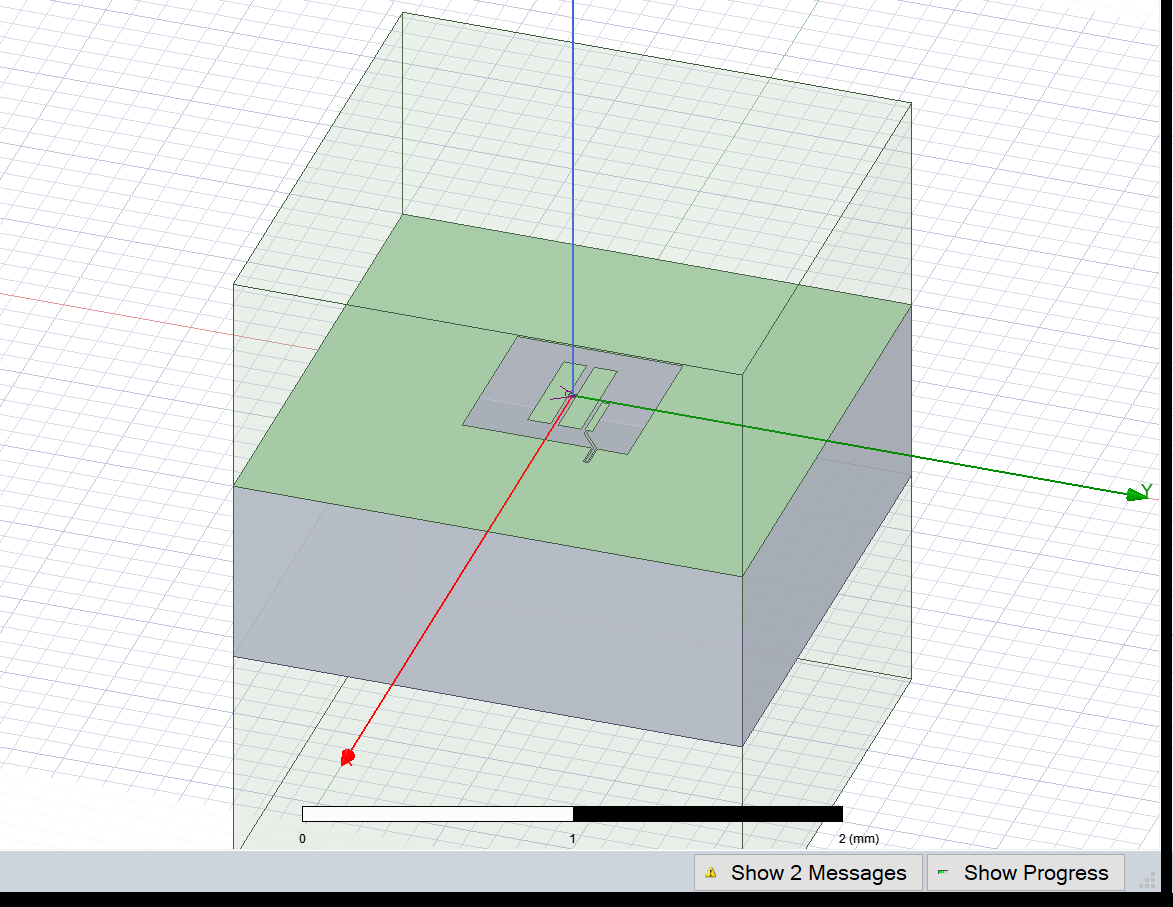

In [10]:
eig_qb.sim.save_screenshot()

(optional) Work directly with the convergence numbers

In [11]:
eig_qb.sim.convergence_f

,re(Mode(1)) [g]
Pass [],
1,3.579716
2,5.168308
3,5.923488
4,6.106727
5,6.198317
6,6.251343


(optional) You can re-run the analysis after varying the parameters.<br>
Not passing the parameter `components` to the `sim.run()` method, skips the rendering and tries to run the analysis on the latest design. If a design is not found, the full metal design is rendered.

In [12]:
eig_qb.sim.setup.min_freq_ghz = 4
eig_qb.sim.run()
eig_qb.sim.convergence_f

INFO 10:35PM [get_setup]: 	Opened setup `Setup2`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 10:35PM [analyze]: Analyzing setup Setup2
10:36PM 19s INFO [get_f_convergence]: Saved convergences to C:\_code_ibmq\qiskit-metal-public\docs\tut\4-Analysis\hfss_eig_f_convergence.csv


,re(Mode(1)) [g]
Pass [],
1,40.055249
2,4.850279
3,5.816798
4,6.039345
5,6.152911
6,6.222742


Verify that the Electro(magnetic) fields look realistic.

INFO 10:36PM [get_setup]: 	Opened setup `Setup2`  (<class 'pyEPR.ansys.HfssEMSetup'>)


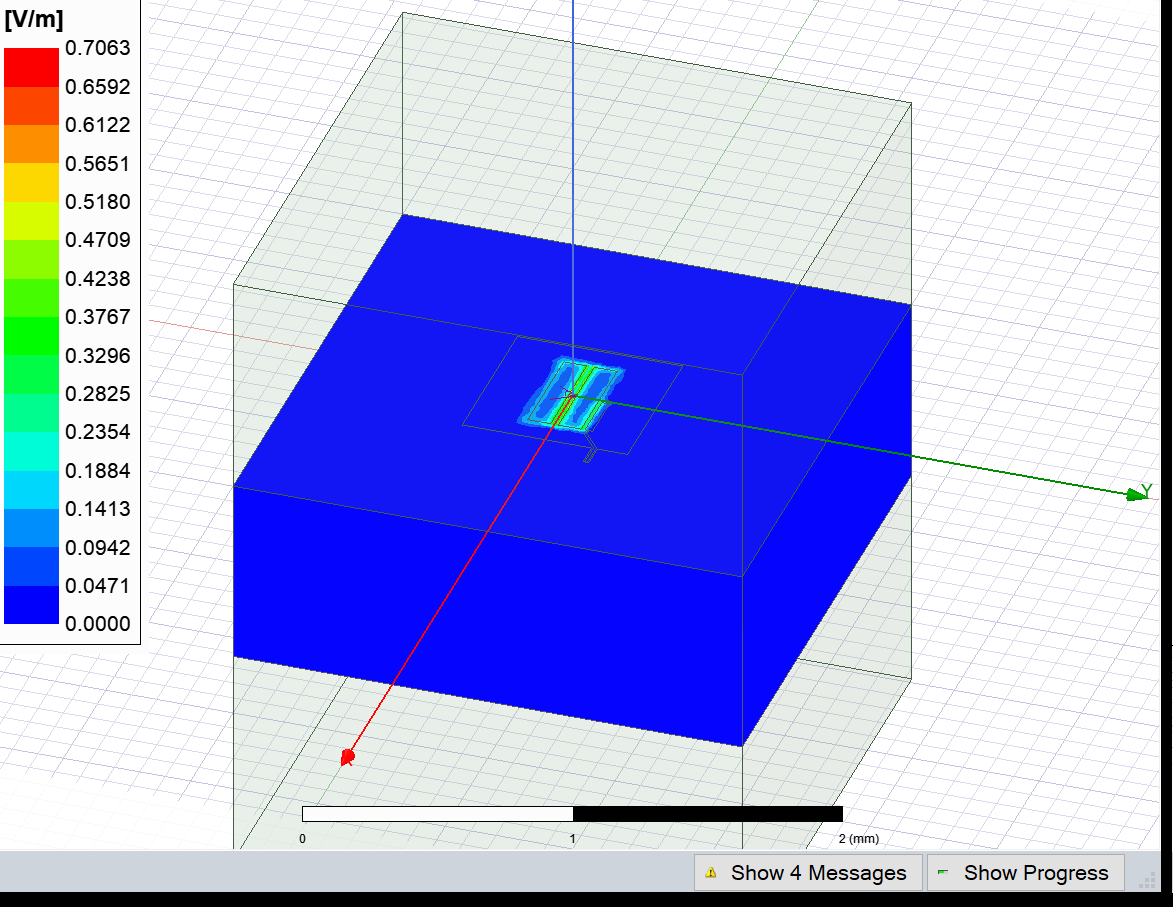

WindowsPath('C:/_code_ibmq/qiskit-metal-public/docs/tut/4-Analysis/ansys.png')

In [13]:
eig_qb.sim.plot_fields('main')   # TODO:::: Ez, normal component.....decide which field typically on the qbit, or on the crossing between meanders
eig_qb.sim.save_screenshot()

(optional) clear the renderer by removing the fields

In [14]:
eig_qb.sim.clear_fields()

### EPR Analysis
#### Setup
Identify the non-linear (Josephson) junctions in the model. You will need to list the junctions in the epr setup.

In this case there's only one junction, namely 'jj'. Let's see what we need to change in the default setup.

In [15]:
eig_qb.setup

{'junctions': {'jj': {'Lj_variable': 'Lj',
   'Cj_variable': 'Cj',
   'rect': '',
   'line': ''}},
 'dissipatives': {'dielectrics_bulk': ['main']},
 'cos_trunc': 8,
 'fock_trunc': 7,
 'sweep_variable': 'Lj'}

The name of the `Lj_variable` and `Cj_variable` match with our model. However it is missing the names of the shapes that identify the junction (`rect` and `line`). Look for those in the renderer and find the name. Then let's change the name (See below).

In [16]:
eig_qb.setup.junctions.jj.rect = 'JJ_rect_Lj_Q1_rect_jj'
eig_qb.setup.junctions.jj.line = 'JJ_Lj_Q1_rect_jj_'
eig_qb.setup

{'junctions': {'jj': {'Lj_variable': 'Lj',
   'Cj_variable': 'Cj',
   'rect': 'JJ_rect_Lj_Q1_rect_jj',
   'line': 'JJ_Lj_Q1_rect_jj_'}},
 'dissipatives': {'dielectrics_bulk': ['main']},
 'cos_trunc': 8,
 'fock_trunc': 7,
 'sweep_variable': 'Lj'}

We will now run epr as a single step. On screen you will observe various information in this order:
* stored energy = Electric and magnetic energy stored in the substrate and the system as a whole.
* EPR analysis results for all modes/variations.
* Spectrum analysis.
* Hamiltonian report.

In [17]:
eig_qb.run_epr()

#### equivalent individual calls
# s = self.setup
# self.epr_start()
# eig_qb.get_stored_energy()
# eig_qb.run_analysis()
# eig_qb.spectrum_analysis(s.cos_trunc, s.fock_trunc)
# eig_qb.report_hamiltonian(s.swp_variable)

Design "Qbit_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Qbit_hfss" info:
	# eigenmodes    1
	# variations    1

        energy_elec_all       = 7.72550321519752e-24
        energy_elec_substrate = 7.10552481480507e-24
        EPR of substrate = 92.0%

        energy_mag    = 4.02001475936871e-26
        energy_mag % of energy_elec_all  = 0.5%
        

Variation 0  [1/1]

  Mode 0 at 6.22 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.5%  3.863e-24  2.01e-26

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 96.75%
	jj              0.904053  (+)        0.0304046
		(U_tot_cap-U_tot_ind)/mean=6.25%
Calculating Qdielectric_main for mode 0 (0/0)
p_dielectric_main_0 = 0.9197491240217418


WARNING 10:36PM [__init__]: <p>Error: <class 'IndexError'></p>



ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project28\Qbit_hfss\2021-08-09 22-36-24.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.133646
dtype: float64

Pm_norm idx =
     jj
0  True
*** P (participation matrix, not normlz.)
         jj
0  0.877377

*** S (sign-bit matrix)
   s_jj
0     1
*** P (participation matrix, normalized.)
      0.99

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       322

*** Chi matrix ND (MHz) 
       361

*** Frequencies O1 PT (MHz)
0    5900.50314
dtype: float64

*** Frequencies ND (MHz)
0    5881.63372
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj,11
eigenmode,
0,5900.5


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj,,
11,0,361.39


# 2. Analyze the CPW resonator by itself
### Update the design in Metal
Connect the transmon to a CPW. <br>
The other end of the CPW connects to an open to ground termination.

In [18]:
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
otg = OpenToGround(design, 'open_to_ground', options=dict(pos_x='1.75mm',  pos_y='0um', orientation='0'))
RouteMeander(design, 'readout',  Dict(
        total_length='6 mm',
        hfss_wire_bonds = True,
        fillet='90 um',
        lead = dict(start_straight='100um'),
        pin_inputs=Dict(
            start_pin=Dict(component='Q1', pin='readout'),
            end_pin=Dict(component='open_to_ground', pin='open')), ))

gui.rebuild()
gui.autoscale()

### Finite Element Eigenmode Analysis

#### Setup

Create a separate analysis object, dedicated to the readout. This allows to retain the Qubit session active, in case we will later need to tweak the design and repeat the simulation. When different renderers are available you could even consider using different more appopriate ones for each simulation steps of this notebook, but for now we will be using the same one.

In [19]:
eig_rd = EPRanalysis(design, "hfss")

For the resonator analysis we will use the default setup. Youn can feel free to edit it the same way we did in section 1.

#### Execute simulation and verify convergence and EM field
Analyze the readout in isolation. Select the readout and terminate it with an open on both ends. Note that we are selecting for this analysis both the `readout` component and the `open_to_ground` component. The `open_to_ground` compoent might feel redundant because we are specifying in that open in the `open_terminations`, and the end converging reult is indeed the same. however the `open_to_ground` appears to help the system to ceonverge faster, so we keep it in there.

In [20]:
eig_rd.sim.run(name="Readout",
               components=['readout', 'open_to_ground'],
               open_terminations=[('readout', 'start'), ('readout', 'end')])
eig_rd.sim.plot_convergences()

INFO 10:36PM [connect_design]: 	Opened active design
	Design:    Readout_hfss [Solution type: Eigenmode]
WARNING 10:36PM [connect_setup]: 	No design setup detected.
WARNING 10:36PM [connect_setup]: 	Creating eigenmode default setup.
INFO 10:36PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 10:36PM [get_setup]: 	Opened setup `Setup1`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 10:36PM [analyze]: Analyzing setup Setup1
10:37PM 56s INFO [get_f_convergence]: Saved convergences to C:\_code_ibmq\qiskit-metal-public\docs\tut\4-Analysis\hfss_eig_f_convergence.csv


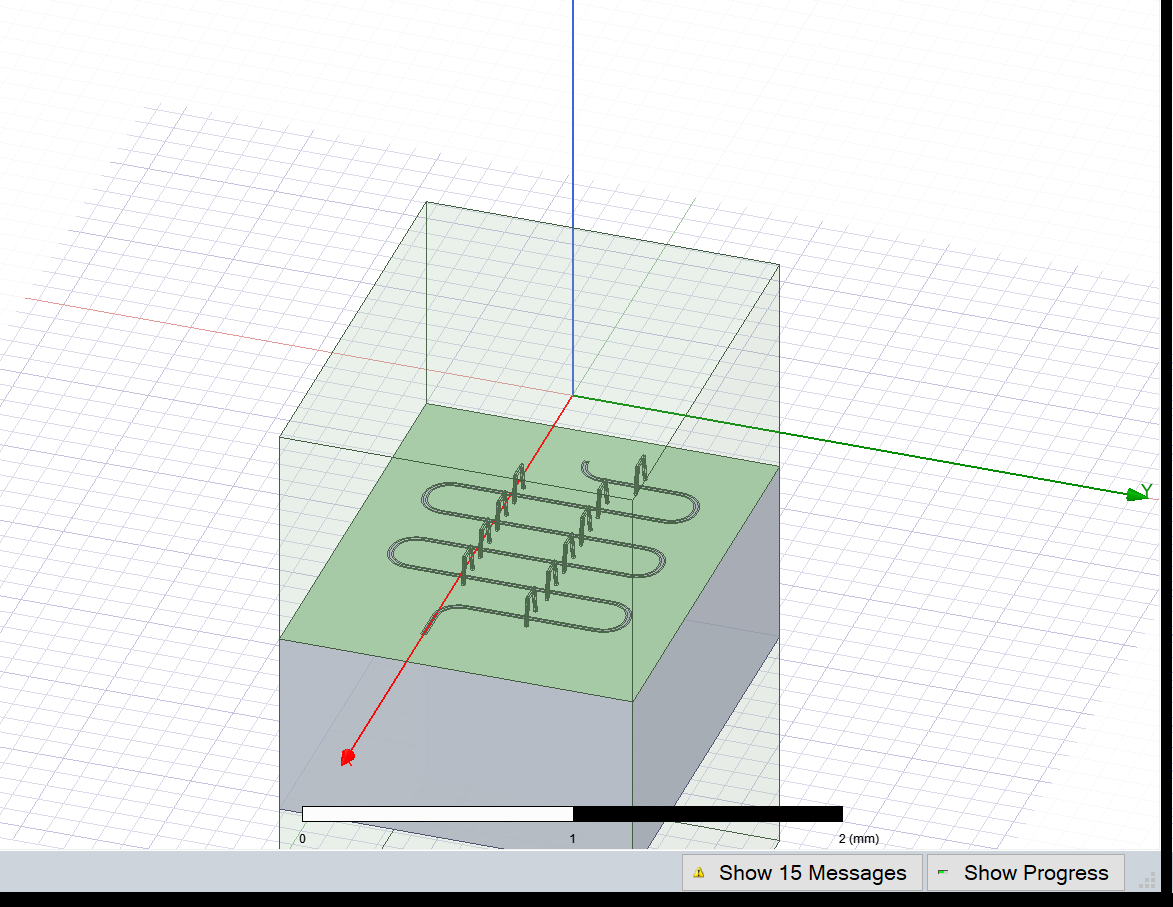

WindowsPath('C:/_code_ibmq/qiskit-metal-public/docs/tut/4-Analysis/ansys.png')

In [21]:
eig_rd.sim.save_screenshot()  # optional

Recover eigenmode frequencies for each variation.

In [22]:
eig_rd.get_frequencies()

Design "Readout_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Readout_hfss" info:
	# eigenmodes    1
	# variations    1


,,Freq. (GHz),Quality Factor
variation,mode,,
0,0,9.699888,inf


Display the Ansys modeler window and plot the E-field on the chip's surface.

INFO 10:38PM [get_setup]: 	Opened setup `Setup1`  (<class 'pyEPR.ansys.HfssEMSetup'>)


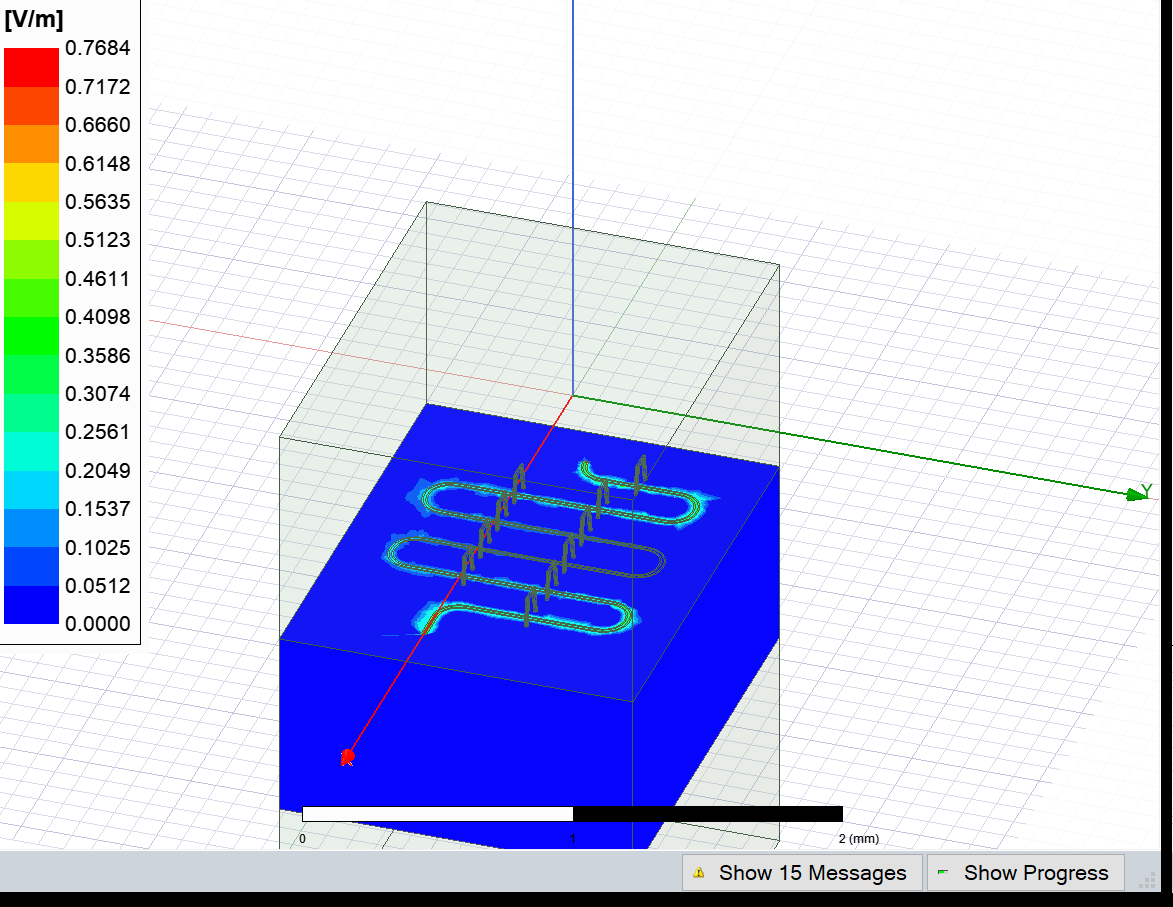

WindowsPath('C:/_code_ibmq/qiskit-metal-public/docs/tut/4-Analysis/ansys.png')

In [23]:
eig_rd.sim.plot_fields('main')
eig_rd.sim.save_screenshot()

#### Refine

If convergence is not complete, or the EM field is unclear, update the number of passes and re-run the flow (below repeated for convenience)

In [24]:
eig_rd.sim.setup.max_passes = 15   # update single setting
eig_rd.sim.run()
eig_rd.sim.plot_convergences()

INFO 10:38PM [get_setup]: 	Opened setup `Setup2`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 10:38PM [analyze]: Analyzing setup Setup2
10:40PM 10s INFO [get_f_convergence]: Saved convergences to C:\_code_ibmq\qiskit-metal-public\docs\tut\4-Analysis\hfss_eig_f_convergence.csv


Display the Ansys modeler window again and plot the E-field on the chip's surface with this updated number of passes. <br>
Note that the bright areas have become much smoother compared to the previous image, indicating better convergence.

INFO 10:40PM [get_setup]: 	Opened setup `Setup2`  (<class 'pyEPR.ansys.HfssEMSetup'>)


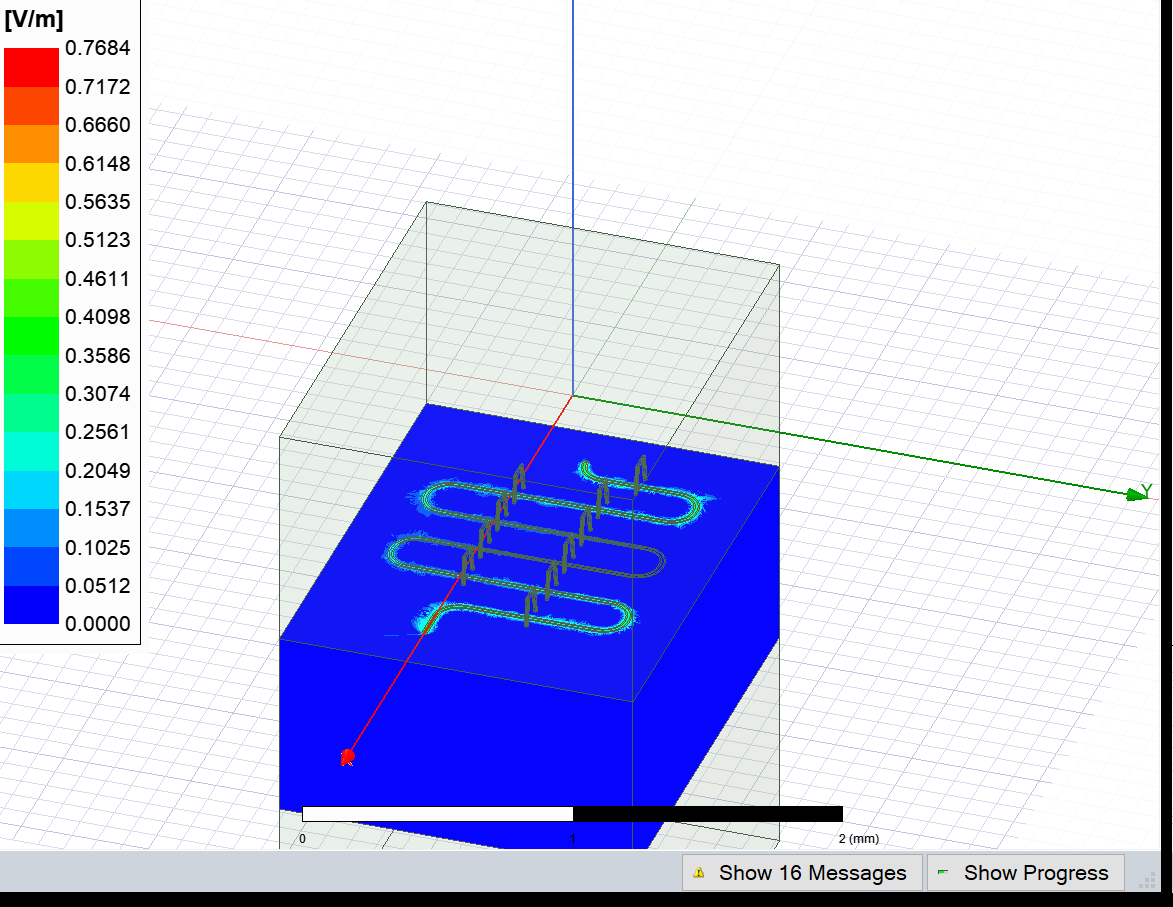

WindowsPath('C:/_code_ibmq/qiskit-metal-public/docs/tut/4-Analysis/ansys.png')

In [25]:
eig_rd.sim.plot_fields('main')
eig_rd.sim.save_screenshot()

### EPR Analysis
Find the electric and magnetic energy stored in the readout system.

In [26]:
eig_rd.run_epr(no_junctions = True)

Design "Readout_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Readout_hfss" info:
	# eigenmodes    1
	# variations    1

        energy_elec_all       = 3.54608697054075e-24
        energy_elec_substrate = 3.2323465843058e-24
        EPR of substrate = 91.2%

        energy_mag    = 3.54608766946939e-24
        energy_mag % of energy_elec_all  = 100.0%
        


# 3. Analyze the combined transmon + CPW resonator system

### Finite Element Eigenmode Analysis

#### Setup

Create a separate analysis object for the combined qbit+readout.

In [27]:
eig_qres = EPRanalysis(design, "hfss")

For the resonator analysis we look for 2 eigenmodes - one with stronger fields near the transmon, the other with stronger fields near the resonator. Therefore let's update the setup accordingly.

In [28]:
eig_qres.sim.setup.n_modes = 2
eig_qres.sim.setup

{'name': 'Setup',
 'reuse_selected_design': True,
 'min_freq_ghz': 1,
 'n_modes': 2,
 'max_delta_f': 0.5,
 'max_passes': 10,
 'min_passes': 1,
 'min_converged': 1,
 'pct_refinement': 30,
 'basis_order': 1,
 'vars': {'Lj': '10 nH', 'Cj': '0 fF'}}

#### Execute simulation and verify convergence and EM field
Analyze the qubit+readout. Select the qubit and the readout, then finalize with open termination on the other pins.

In [29]:
eig_qres.sim.run(name="TransmonResonator",
                 components=['Q1', 'readout', 'open_to_ground'],
                 open_terminations=[('readout', 'end')])
eig_qres.sim.plot_convergences()

INFO 10:40PM [connect_design]: 	Opened active design
	Design:    TransmonResonator_hfss [Solution type: Eigenmode]
WARNING 10:40PM [connect_setup]: 	No design setup detected.
WARNING 10:40PM [connect_setup]: 	Creating eigenmode default setup.
INFO 10:40PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 10:40PM [get_setup]: 	Opened setup `Setup1`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 10:40PM [analyze]: Analyzing setup Setup1
10:43PM 51s INFO [get_f_convergence]: Saved convergences to C:\_code_ibmq\qiskit-metal-public\docs\tut\4-Analysis\hfss_eig_f_convergence.csv


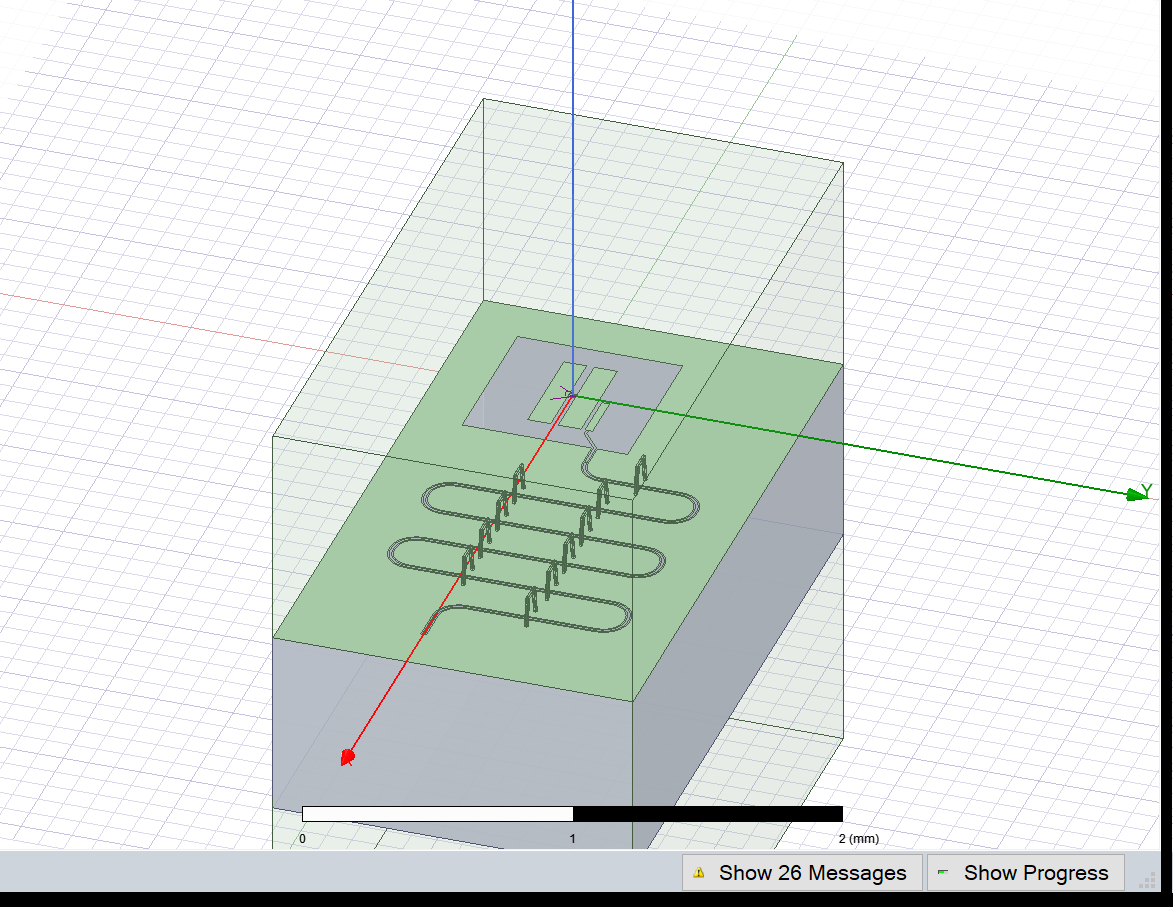

WindowsPath('C:/_code_ibmq/qiskit-metal-public/docs/tut/4-Analysis/ansys.png')

In [30]:
eig_qres.sim.save_screenshot()  # optional

Display the Ansys modeler window again and plot the E-field on the chip's surface. you can select which of the two modes to visualize.

INFO 10:43PM [get_setup]: 	Opened setup `Setup1`  (<class 'pyEPR.ansys.HfssEMSetup'>)


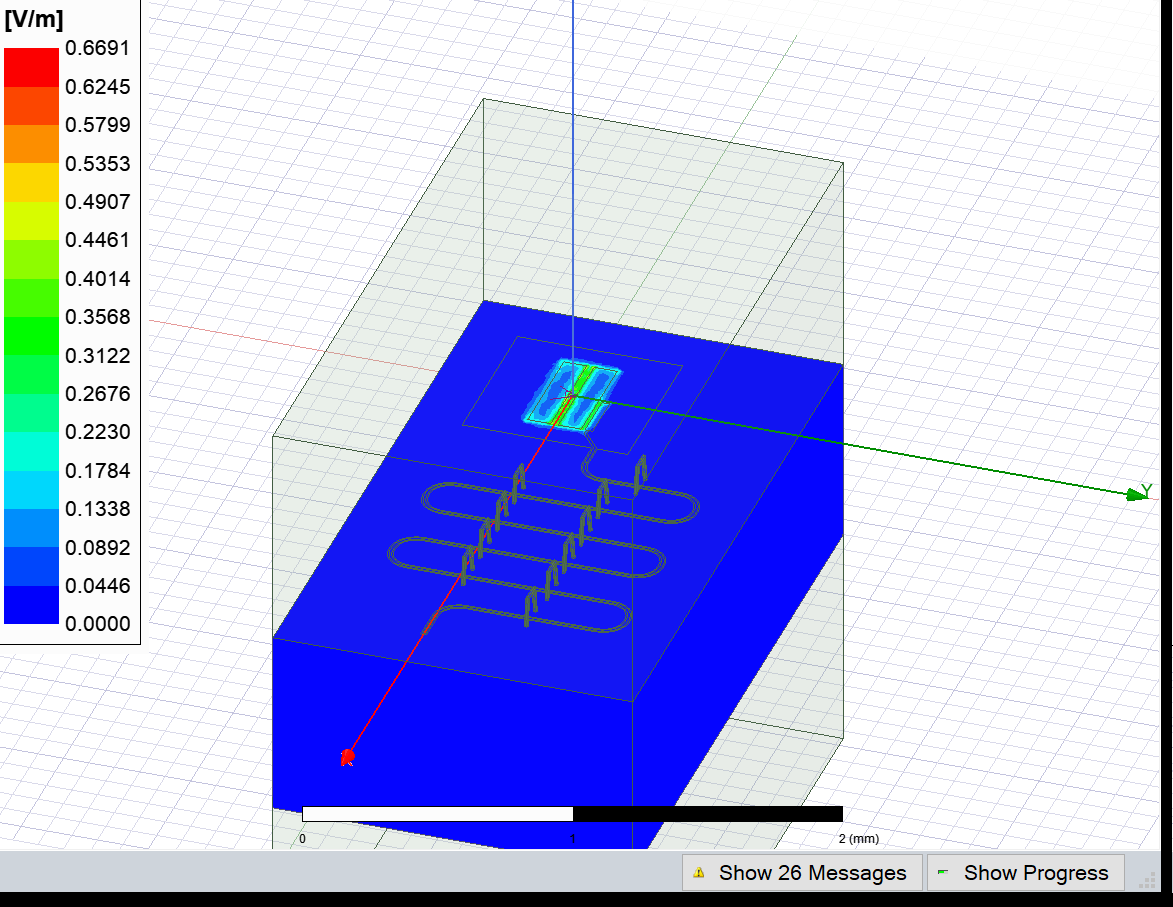

WindowsPath('C:/_code_ibmq/qiskit-metal-public/docs/tut/4-Analysis/ansys.png')

In [31]:
eig_qres.sim.plot_fields('main', eigenmode=1)
eig_qres.sim.save_screenshot()

### EPR Analysis

Similarly to section 1, we need to pass to the renderer the names of the shapes that identify the junction (`rect` and `line`). These should be the same as in section 1, or you can look again for those in the renderer.

In [32]:
eig_qres.setup.junctions.jj.rect = 'JJ_rect_Lj_Q1_rect_jj'
eig_qres.setup.junctions.jj.line = 'JJ_Lj_Q1_rect_jj_'
eig_qres.setup

{'junctions': {'jj': {'Lj_variable': 'Lj',
   'Cj_variable': 'Cj',
   'rect': 'JJ_rect_Lj_Q1_rect_jj',
   'line': 'JJ_Lj_Q1_rect_jj_'}},
 'dissipatives': {'dielectrics_bulk': ['main']},
 'cos_trunc': 8,
 'fock_trunc': 7,
 'sweep_variable': 'Lj'}

We will now run epr as a single step. On screen you will observe various information in this order:
* stored energy = Electric and magnetic energy stored in the substrate and the system as a whole.
* EPR analysis results for all modes/variations.
* Spectrum analysis.
* Hamiltonian report.

In [33]:
eig_qres.run_epr()

Design "TransmonResonator_hfss" info:
	# eigenmodes    2
	# variations    1
Design "TransmonResonator_hfss" info:
	# eigenmodes    2
	# variations    1

        energy_elec_all       = 7.74800096501779e-24
        energy_elec_substrate = 7.11845568544785e-24
        EPR of substrate = 91.9%

        energy_mag    = 6.71993890387355e-26
        energy_mag % of energy_elec_all  = 0.9%
        

Variation 0  [1/1]

  Mode 0 at 6.22 GHz   [1/2]
    Calculating ℰ_magnetic,ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.1%  3.874e-24  3.36e-26

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 97.04%
	jj              0.990893  (+)        0.0302452
		(U_tot_cap-U_tot_ind)/mean=1.51%
Calculating Qdielectric_main for mode 0 (0/1)
p_dielectric_main_0 = 0.9187473927258998

  Mode 1 at 9.33 GHz   [2/2]
    Calculating ℰ_magnetic,ℰ_electr

WARNING 10:44PM [__init__]: <p>Error: <class 'IndexError'></p>



ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project28\TransmonResonator_hfss\2021-08-09 22-43-59.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.030829
1    1.031477
dtype: float64

Pm_norm idx =
      jj
0   True
1  False
*** P (participation matrix, not normlz.)
         jj
0  0.961803
1  0.003053

*** S (sign-bit matrix)
   s_jj
0     1
1     1
*** P (participation matrix, normalized.)
      0.99
    0.0031

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       291     2.69
      2.69   0.0062

*** Chi matrix ND (MHz) 
       324     2.29
      2.29  0.00453

*** Frequencies O1 PT (MHz)
0    5925.626329
1    9326.061633
dtype: float64

*** Frequencies ND (MHz)
0    5910.137715
1    9326.115494
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0, 1]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj,10
eigenmode,
0,5925.63
1,9326.06


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

0         1
Lj                    
10 0  323.51  2.29e+00
   1    2.29  4.53e-03

Once you are sure you are done with the qubit analysis, please explicitly release the Ansys session to allow for a smooth close of the external tool.

In [34]:
eig_qb.sim.close()

In [35]:
eig_rd.sim.close()

In [36]:
eig_qres.sim.close()

# 4. Analyze a coupled 2-transmon system
### Create the design

This is a different system than the one analyzed in sections 1,2,3. Therefore, let's start by deleting the design currntly in the Qiskit Metal GUI (if any).

In [37]:
design.delete_all_components()

Next, we create the `TwoTransmon` design, consisting of 2 transmons connected by a short coupler.

In [38]:
from qiskit_metal.qlibrary.qubits.transmon_pocket import TransmonPocket
from qiskit_metal.qlibrary.tlines.straight_path import RouteStraight

q1 = TransmonPocket(design, 'Q1', options = dict(
    pad_width = '425 um', 
    pocket_height = '650um',
    connection_pads=dict(
        readout = dict(loc_W=+1,loc_H=+1, pad_width='200um')
    )))

q2 = TransmonPocket(design, 'Q2', options = dict(
    pos_x = '1.0 mm',
    pad_width = '425 um', 
    pocket_height = '650um',
    connection_pads=dict(
        readout = dict(loc_W=-1,loc_H=+1, pad_width='200um')
    )))

coupler = RouteStraight(design, 'coupler', Dict(hfss_wire_bonds = True,
        pin_inputs=Dict(
            start_pin=Dict(component='Q1', pin='readout'),
            end_pin=Dict(component='Q2', pin='readout')), ))

gui.rebuild()
gui.autoscale()

Let's observe the current table describing the junctions in the qiskit metal design

In [39]:
design.qgeometry.tables['junction']

,component,name,geometry,layer,subtract,helper,chip,width,hfss_inductance,hfss_capacitance,hfss_resistance,hfss_mesh_kw_jj,q3d_inductance,q3d_capacitance,q3d_resistance,q3d_mesh_kw_jj,gds_cell_name
0,4,rect_jj,"LINESTRING (0.00000 -0.01500, 0.00000 0.01500)",1,False,False,main,0.02,10nH,0,0,0.000007,10nH,0,0,0.000007,my_other_junction
1,5,rect_jj,"LINESTRING (1.00000 -0.01500, 1.00000 0.01500)",1,False,False,main,0.02,10nH,0,0,0.000007,10nH,0,0,0.000007,my_other_junction


You can observe in the table above that every junction has been assigned a default inductance, capacitance and resistance values, based on the originating component class `default_options`. In this example we intend to replace those values with a variable name, which will later be set directly in the renderer. Therefore, let's proceed with updating these values in the qubit instances, and then propagate the update to the table with a `rebuild()`.
After executing the cell below, you can observe the change by re-executing the cell above.

In [40]:
# TODO: fold this inside either an analysis class method, or inside the analysis class setup

qcomps = design.components  # short handle (alias)
qcomps['Q1'].options['hfss_inductance'] = 'Lj1'
qcomps['Q1'].options['hfss_capacitance'] = 'Cj1'
qcomps['Q2'].options['hfss_inductance'] = 'Lj2'
qcomps['Q2'].options['hfss_capacitance'] = 'Cj2'
gui.rebuild()  # line needed to propagate the updates from the qubit instance into the junction design table
gui.autoscale()

### Finite Element Eigenmode Analysis

#### Setup

Let's start the analysis by creating the appropriate analysis object.

In [41]:
from qiskit_metal.analyses.quantization import EPRanalysis
eig_2qb = EPRanalysis(design, "hfss")

Now let us update the setup of this analysis to reflect what we plan to do:
* define the variables that we have assigned to the inductance and capacitance of the junctions;
* increase accuracy of the convergence;
* observe the eigenmode corresponding to both qubits.

In [42]:
eig_2qb.sim.setup.max_passes = 15
eig_2qb.sim.setup.max_delta_f = 0.05
eig_2qb.sim.setup.n_modes = 2
eig_2qb.sim.setup.vars = Dict(Lj1= '13 nH', Cj1= '0 fF',
                           Lj2= '9 nH', Cj2= '0 fF')
eig_2qb.sim.setup

{'name': 'Setup',
 'reuse_selected_design': True,
 'min_freq_ghz': 1,
 'n_modes': 2,
 'max_delta_f': 0.05,
 'max_passes': 15,
 'min_passes': 1,
 'min_converged': 1,
 'pct_refinement': 30,
 'basis_order': 1,
 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF', 'Lj2': '9 nH', 'Cj2': '0 fF'}}

By default, the analysis will be done on all components that we will list in the `run_sim()` method, but the analysis needs to know how much of the ground plane around the qubit to consider. One could use the declared chip dimension by passing the parameter `bux_plus_buffer = False` to the `run_sim()` method. However, its default (when said parameter is omitted) is to consider the ground plane to be as big as the minimum enclosing rectangle plus a set buffer. The default buffer value is `200um`, while in the cell below we will increase as an example that buffer to `500um`.

In [43]:
# TODO: fold this inside either an analysis class method, or inside the analysis class setup

eig_2qb.sim.renderer.options['x_buffer_width_mm'] = 0.5
eig_2qb.sim.renderer.options['y_buffer_width_mm'] = 0.5
eig_2qb.sim.renderer.options

{'Lj': '10nH',
 'Cj': 0,
 '_Rj': 0,
 'max_mesh_length_jj': '7um',
 'project_path': None,
 'project_name': None,
 'design_name': None,
 'x_buffer_width_mm': 0.5,
 'y_buffer_width_mm': 0.5,
 'wb_threshold': '400um',
 'wb_offset': '0um',
 'wb_size': 5,
 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1',
  'UserSpecifyName': '0',
  'UserSpecifyFolder': '0',
  'QuantityName': 'Mag_E',
  'PlotFolder': 'E Field',
  'StreamlinePlot': 'False',
  'AdjacentSidePlot': 'False',
  'FullModelPlot': 'False',
  'IntrinsicVar': "Phase='0deg'",
  'PlotGeomInfo_0': '1',
  'PlotGeomInfo_1': 'Surface',
  'PlotGeomInfo_2': 'FacesList',
  'PlotGeomInfo_3': '1'}}

Let's finally run the cap extraction simulation and observe the convergence.

In [44]:
eig_2qb.sim.run(name="TwoTransmons",
                components=['coupler', 'Q1', 'Q2'])

INFO 10:44PM [connect_project]: Connecting to Ansys Desktop API...
INFO 10:44PM [load_ansys_project]: 	Opened Ansys App
INFO 10:44PM [load_ansys_project]: 	Opened Ansys Desktop v2020.2.0
INFO 10:44PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    D:/dennis_wang/
	Project:   Project28
INFO 10:44PM [connect_design]: 	Opened active design
	Design:    TransmonResonator_hfss [Solution type: Eigenmode]
INFO 10:44PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 10:44PM [connect]: 	Connected to project "Project28" and design "TransmonResonator_hfss" 😀 

INFO 10:44PM [connect_design]: 	Opened active design
	Design:    TwoTransmons_hfss [Solution type: Eigenmode]
WARNING 10:44PM [connect_setup]: 	No design setup detected.
WARNING 10:44PM [connect_setup]: 	Creating eigenmode default setup.
INFO 10:44PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 10:44PM [get_setup]: 	Opened setup `Setup1`  (<class 'pyEPR.ansys.HfssEMSetup'>)

In [45]:
eig_2qb.sim.plot_convergences()

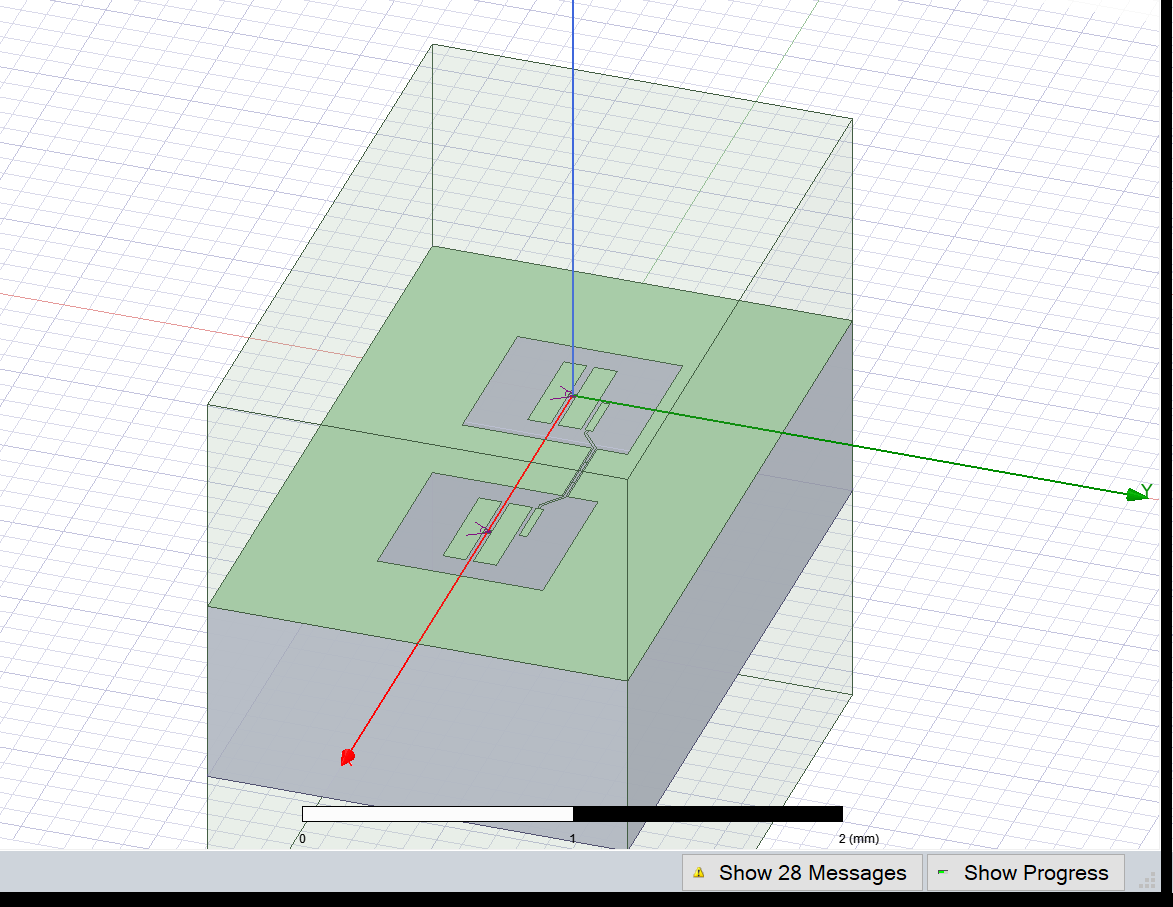

WindowsPath('C:/_code_ibmq/qiskit-metal-public/docs/tut/4-Analysis/ansys.png')

In [46]:
eig_2qb.sim.save_screenshot()  # optional

Display the Ansys modeler window again and plot the E-field on the chip's surface. Since we have analyzed 2 modes, you will need to select which mode to visualize. The default is mode 1, but the mode can inclusively be any integer between 1 and `setup.n_modes`.

INFO 10:52PM [get_setup]: 	Opened setup `Setup1`  (<class 'pyEPR.ansys.HfssEMSetup'>)


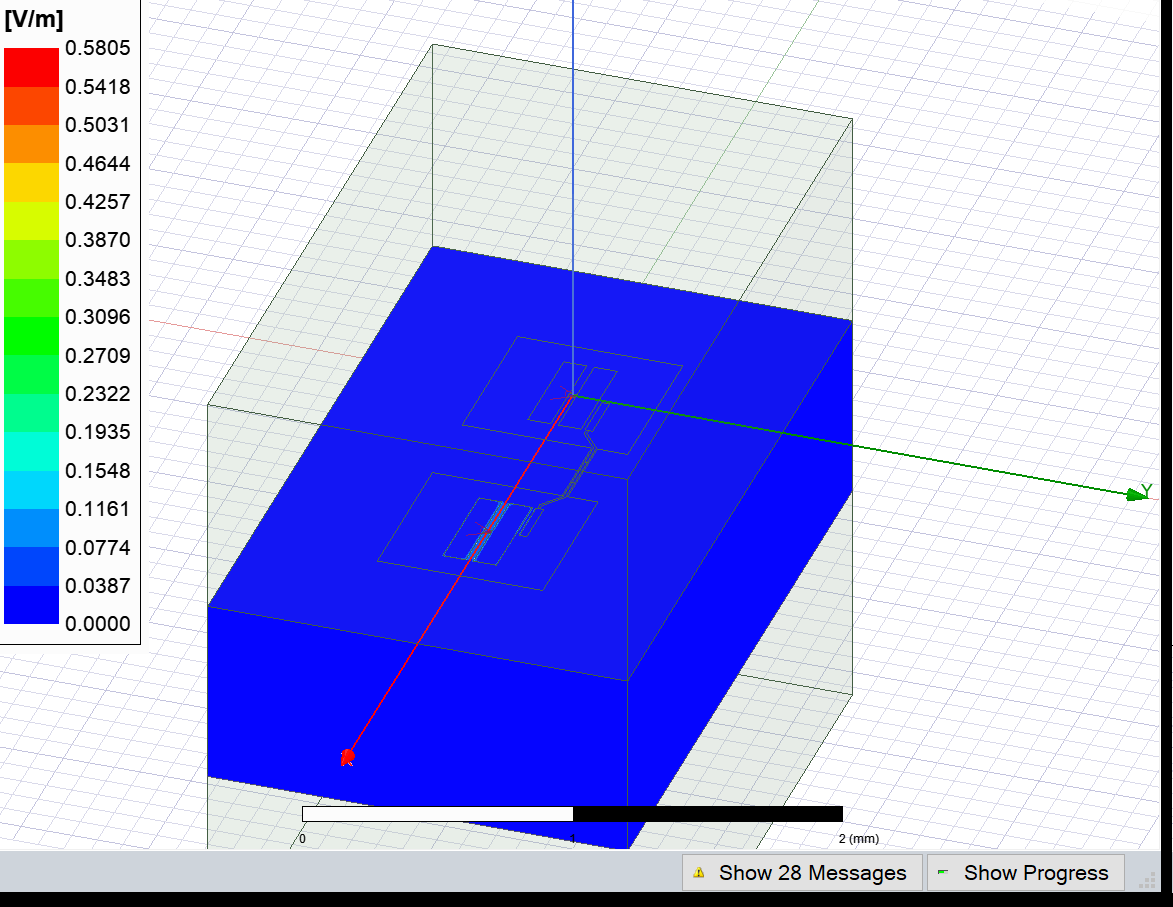

WindowsPath('C:/_code_ibmq/qiskit-metal-public/docs/tut/4-Analysis/ansys.png')

In [47]:
eig_2qb.sim.plot_fields('main', eigenmode=2)
eig_2qb.sim.save_screenshot()

### EPR Analysis
#### Setup
Identify the non-linear (Josephson) junctions in the model. in this case there are 2 junctions, which we will refer to as `jj1` and `jj2`. Also define the dissipative reference shapes. Remove the default junction and create the two.

In [48]:
del eig_2qb.setup.junctions['jj']

In [49]:
eig_2qb.setup.junctions.jj1 = Dict(rect='JJ_rect_Lj_Q1_rect_jj', line='JJ_Lj_Q1_rect_jj_',
                  Lj_variable='Lj1', Cj_variable='Cj1')
eig_2qb.setup.junctions.jj2 = Dict(rect='JJ_rect_Lj_Q2_rect_jj', line='JJ_Lj_Q2_rect_jj_',
                  Lj_variable='Lj2', Cj_variable='Cj2')
eig_2qb.setup.sweep_variable = 'Lj1'
eig_2qb.setup

{'junctions': {'jj1': {'rect': 'JJ_rect_Lj_Q1_rect_jj',
   'line': 'JJ_Lj_Q1_rect_jj_',
   'Lj_variable': 'Lj1',
   'Cj_variable': 'Cj1'},
  'jj2': {'rect': 'JJ_rect_Lj_Q2_rect_jj',
   'line': 'JJ_Lj_Q2_rect_jj_',
   'Lj_variable': 'Lj2',
   'Cj_variable': 'Cj2'}},
 'dissipatives': {'dielectrics_bulk': ['main']},
 'cos_trunc': 8,
 'fock_trunc': 7,
 'sweep_variable': 'Lj1'}

Find the electric and magnetic energy stored in the substrate and the system as a whole.

In [50]:
eig_2qb.run_epr()

Design "TwoTransmons_hfss" info:
	# eigenmodes    2
	# variations    1
Design "TwoTransmons_hfss" info:
	# eigenmodes    2
	# variations    1

        energy_elec_all       = 2.01926030136048e-25
        energy_elec_substrate = 1.86157115120032e-25
        EPR of substrate = 92.2%

        energy_mag    = 1.19184318501109e-27
        energy_mag % of energy_elec_all  = 0.6%
        

Variation 0  [1/1]

  Mode 0 at 5.63 GHz   [1/2]
    Calculating ℰ_magnetic,ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.6%  1.842e-25 7.433e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 96.85%
	jj1             0.995334  (+)        0.0323716
		Energy fraction (Lj over Lj&Cj)= 97.80%
	jj2             0.000371363  (+)        8.36166e-06
		(U_tot_cap-U_tot_ind)/mean=1.61%
Calculating Qdielectric_main for mode 0 (0/1)
p_dielectric_main_0 =

WARNING 10:53PM [__init__]: <p>Error: <class 'IndexError'></p>



ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project28\TwoTransmons_hfss\2021-08-09 22-53-00.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.032715
1    1.033081
dtype: float64

Pm_norm idx =
     jj1    jj2
0   True  False
1  False   True
*** P (participation matrix, not normlz.)
        jj1       jj2
0  0.964116  0.000360
1  0.000365  0.961989

*** S (sign-bit matrix)
   s_jj1  s_jj2
0      1      1
1      1      1
*** P (participation matrix, normalized.)
         1  0.00036
   0.00036     0.99

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       312    0.463
     0.463      311

*** Chi matrix ND (MHz) 
       353     1.04
      1.04      344

*** Frequencies O1 PT (MHz)
0    5316.502727
1    6455.124200
dtype: float64

*** Frequencies ND (MHz)
0    5296.470709
1    6439.252259
dty

INFO 10:53PM [__del__]: Disconnected from Ansys HFSS


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
eigenmode,
0,5316.50
1,6455.12


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

0       1
Lj1                  
13  0  353.30    1.04
    1    1.04  344.23

Release Ansys's session

In [51]:
eig_2qb.sim.close()

(optional) **final wrap**: Close the gui by removing the # in the line below.

In [52]:
# gui.main_window.close()